# Intercity-Comparison of Neighborhoods
# Problem Overview:
The assignment problem can be broadly described in the following points below. 
1. Different cities have specific neighborhoods, which have specific characteristics/facilities/infrastructure, in terms of restaurants, hospitals, parks, etc. So, the question that remains to be answered is, given two cities and their neighborhood profiles, can we identify neighborhoods across the two cities that are similar in terms of the above characteristics? Identifying this will be important for individuals who wish to move from one city to the other, who in turn, would be looking for similar neighborhoods to settle in. For people visiting one city from the one from the other, who are specifically looking for neighborhoods similar to the ones that they like in their home town, such an analysis would provide the clues.
2.  Can we identify the exact differences between the neighborhoods, in terms of which characteristics are specifically high or lower in numbers/frequencies in one group of neighborhoods as compared to the others? This will be important as it will help individuals to look for neighborhood based on their choices in terms of hospitals, restaurants, location, etc. This will also help people who are willing to start a business that targets specific neighborhoods or neighborhoods that lack specific infra in which the individual is interested to start a business.

# The data that will be used are described as follows.
1. We will be using neighborhood data from three different cities, namely New York and Toronto for which we already have the neighborhood data along with postal codes. We can also get the neighborhood from a geographically far city like Singapore available at onemap.SG. Once, we have the neighborhood, we can get the latitude and longitude data.
2. We can then use the FourSquare API to get the neighborhood details/venues by categories. For each city, the venue-neighborhood dataframes that are thus obtained can be merged with an additional column containing city names.
3. Multivariate analysis, like Principal Component analysis, can then be performed to identify how similar are the three cities in terms of their neighborhood and if we can get specific inter-city clusters of neighborhoods.
4. We can then group neighborhoods based on the venue profiles.
5. Once and if we get clusters, we can identify neighborhoods in each cluster, as well as what each cluster lacks or has an over-representation of.

# First step is to download all libraries that are necessary

In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

#FourSquare ID and Credential
CLIENT_ID = 'ETCGJWK2O2IN34WPNMUUBEKIKXT2UPALCTVHAPLIKW5WN5WX' # your Foursquare ID
CLIENT_SECRET = 'TXKXCFEK4MRY2SAM4F0ORZ2HDLTH0APWGF31BGBS2EXY12DP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Libraries imported.
Your credentails:
CLIENT_ID: ETCGJWK2O2IN34WPNMUUBEKIKXT2UPALCTVHAPLIKW5WN5WX
CLIENT_SECRET:TXKXCFEK4MRY2SAM4F0ORZ2HDLTH0APWGF31BGBS2EXY12DP


# Creating the datasets for each city
Now for each city, we are going to create dataframes. Each dataframe will contain the following columns first. 
1. City
2. Neighborhood
3. Latitude
4. Longitude

Subsequently, when we have the data for the venues within each neighborhood, we can use one-hot encoding to get the venue-wise frequency columns for each kind of venue. Let's start with the cities.

# 1. New York

In [3]:
#Parse the json to create a dataframe with the above columns
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['City', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    city = "NewYork"
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'City': city,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print(ny_neighborhoods)

        City               Neighborhood   Latitude  Longitude
0    NewYork                  Wakefield  40.894705 -73.847201
1    NewYork                 Co-op City  40.874294 -73.829939
2    NewYork                Eastchester  40.887556 -73.827806
3    NewYork                  Fieldston  40.895437 -73.905643
4    NewYork                  Riverdale  40.890834 -73.912585
5    NewYork                Kingsbridge  40.881687 -73.902818
6    NewYork                Marble Hill  40.876551 -73.910660
7    NewYork                   Woodlawn  40.898273 -73.867315
8    NewYork                    Norwood  40.877224 -73.879391
9    NewYork             Williamsbridge  40.881039 -73.857446
10   NewYork                 Baychester  40.866858 -73.835798
11   NewYork             Pelham Parkway  40.857413 -73.854756
12   NewYork                City Island  40.847247 -73.786488
13   NewYork               Bedford Park  40.870185 -73.885512
14   NewYork         University Heights  40.855727 -73.910416
15   New

In [4]:
#Now lets get the venues iteratively for the locations
# define the dataframe columns
column_names = ['City', 'Neighborhood', 'VenueType'] 

# instantiate the dataframe
ny_neighborhoods_venuetypes = pd.DataFrame(columns=column_names)

for i in range(1,ny_neighborhoods.shape[0]):
    
    temp_latitude = ny_neighborhoods.iloc[i,2]
    temp_longitude = ny_neighborhoods.iloc[i,3]
    neighborhood_name = ny_neighborhoods.iloc[i,1]
    # type your answer here
    LIMIT = 100
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        temp_latitude, 
        temp_longitude, 
        radius, 
        LIMIT)

    results = requests.get(url).json()

    print(i)
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON
    for j in range(1,nearby_venues.shape[0]):
       # print(i,j)
        ny_neighborhoods_venuetypes = ny_neighborhoods_venuetypes.append({'City': "New York",
                                         'Neighborhood': neighborhood_name,
                                         'VenueType': str(json_normalize(nearby_venues['venue.categories'][j])['name'].values)}, ignore_index=True)

        




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


KeyError: 'groups'

In [5]:
ny_neighborhoods_venuetypes

,City,Neighborhood,VenueType
0,New York,Co-op City,['Discount Store']
1,New York,Co-op City,['Pharmacy']
2,New York,Co-op City,['Ice Cream Shop']
3,New York,Co-op City,['Fast Food Restaurant']
4,New York,Co-op City,['Grocery Store']
5,New York,Co-op City,['Restaurant']
6,New York,Co-op City,['Baseball Field']
7,New York,Co-op City,['Mattress Store']
8,New York,Co-op City,['Chinese Restaurant']
9,New York,Co-op City,['Fried Chicken Joint']


In [25]:
ny_neighborhoods_grouped = ny_neighborhoods_venuetypes.join(pd.get_dummies(ny_neighborhoods_venuetypes['VenueType'])).groupby('Neighborhood').max()

In [ ]:
ny_neighborhoods_grouped = ny_neighborhoods_grouped.drop(['VenueType'],axis=1)

In [31]:
ny_neighborhoods_grouped.to_csv(r'NY_Neighborhoods_Grouped.csv')

# 2.Toronto

In [11]:
from bs4 import BeautifulSoup
import requests # library to handle requests
source=requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source,"lxml")

import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np




In [12]:
Borough = {}
Neighborhood = {}

for location_row in soup.table.find_all('tr'):
    location_data=location_row.text
    postcode=location_data.split('\n')[1]
    borough=location_data.split('\n')[2]
    neighborhood=location_data.split('\n')[3]
    if(borough != "Not assigned"):
        Borough[postcode] = borough
        if(neighborhood != "Not assigned"):
            #if(postcode in Neighborhood.keys()):
               # Neighborhood[postcode] = Neighborhood[postcode] + ", " + neighborhood
            Neighborhood[postcode] = neighborhood
        else:
            neighborhood = borough
            #if(postcode in Neighborhood.keys()):
                #Neighborhood[postcode] = Neighborhood[postcode] + ", " + neighborhood
            Neighborhood[postcode] = neighborhood


tr_neighborhoods = pd.DataFrame(index=np.arange(len(Borough.keys())),columns=['PostalCode','City', 'Neighborhood'])


i=0
for postcode in Borough.keys():
    tr_neighborhoods.loc[i,'City']="Toronto"
    tr_neighborhoods.loc[i,'PostalCode']=postcode
    tr_neighborhoods.loc[i,'Neighborhood']=Neighborhood[postcode]
    i=i+1

In [13]:
tr_neighborhoods = tr_neighborhoods.drop(0)
tr_neighborhoods

,PostalCode,City,Neighborhood
1,M3A,Toronto,Parkwoods
2,M4A,Toronto,Victoria Village
3,M5A,Toronto,Regent Park
4,M6A,Toronto,Lawrence Manor
5,M7A,Toronto,Queen's Park
6,M9A,Toronto,Islington Avenue
7,M1B,Toronto,Malvern
8,M3B,Toronto,Don Mills North
9,M4B,Toronto,Parkview Hill
10,M5B,Toronto,Garden District


In [14]:
coordinate_df = pd.read_csv("Geospatial_Coordinates.csv")
location_with_coordinate_df = pd.DataFrame(index=range(1,len(Borough.keys())),columns=['PostalCode', 'City', 'Neighborhood','Latitude','Longitude'])
location_with_coordinate_df.loc[tr_neighborhoods.index.tolist()[0],'PostalCode'] = tr_neighborhoods.loc[tr_neighborhoods.index.tolist()[0],'PostalCode']   
coordinate_df.index = coordinate_df['Postal Code']

for row in range(1,len(Borough.keys())):   
    location_with_coordinate_df.loc[row,'PostalCode'] = tr_neighborhoods.loc[row,'PostalCode']
    location_with_coordinate_df.loc[row,'City'] = "Toronto"
    location_with_coordinate_df.loc[row,'Neighborhood'] = tr_neighborhoods.loc[row,'Neighborhood']
    location_with_coordinate_df.loc[row,'Latitude'] = coordinate_df.loc[tr_neighborhoods.loc[row,'PostalCode'],'Latitude'] 
    location_with_coordinate_df.loc[row,'Longitude'] = coordinate_df.loc[tr_neighborhoods.loc[row,'PostalCode'],'Longitude'] 
tr_neighborhoods = location_with_coordinate_df.drop('PostalCode',axis=1)
print(tr_neighborhoods)

        City                                       Neighborhood Latitude  \
1    Toronto                                          Parkwoods  43.7533   
2    Toronto                                   Victoria Village  43.7259   
3    Toronto                                        Regent Park  43.6543   
4    Toronto                                     Lawrence Manor  43.7185   
5    Toronto                                       Queen's Park  43.6623   
6    Toronto                                   Islington Avenue  43.6679   
7    Toronto                                            Malvern  43.8067   
8    Toronto                                    Don Mills North  43.7459   
9    Toronto                                      Parkview Hill  43.7064   
10   Toronto                                    Garden District  43.6572   
11   Toronto                                          Glencairn  43.7096   
12   Toronto                                    West Deane Park  43.6509   
13   Toronto

In [61]:
#FourSquare ID and Credential
CLIENT_ID = 'ETCGJWK2O2IN34WPNMUUBEKIKXT2UPALCTVHAPLIKW5WN5WX' # your Foursquare ID
CLIENT_SECRET = 'TXKXCFEK4MRY2SAM4F0ORZ2HDLTH0APWGF31BGBS2EXY12DP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#Now lets get the venues iteratively for the locations
# define the dataframe columns
column_names = ['City', 'Neighborhood', 'VenueType'] 

# instantiate the dataframe
tr_neighborhoods_venuetypes = pd.DataFrame(columns=column_names)

for i in range(1,tr_neighborhoods.shape[0]):
    
    temp_latitude = tr_neighborhoods.iloc[i,2]
    temp_longitude = tr_neighborhoods.iloc[i,3]
    neighborhood_name = tr_neighborhoods.iloc[i,1]
    # type your answer here
    LIMIT = 100
    radius = 500
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        temp_latitude, 
        temp_longitude, 
        radius, 
        LIMIT)

    results = requests.get(url).json()

    print(i)
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON
    for j in range(1,nearby_venues.shape[0]):
       # print(i,j)
        tr_neighborhoods_venuetypes = tr_neighborhoods_venuetypes.append({'City': "Toronto",
                                         'Neighborhood': neighborhood_name,
                                         'VenueType': str(json_normalize(nearby_venues['venue.categories'][j])['name'].values)}, ignore_index=True)

Your credentails:
CLIENT_ID: ETCGJWK2O2IN34WPNMUUBEKIKXT2UPALCTVHAPLIKW5WN5WX
CLIENT_SECRET:TXKXCFEK4MRY2SAM4F0ORZ2HDLTH0APWGF31BGBS2EXY12DP
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


In [62]:
tr_neighborhoods_venuetypes

,City,Neighborhood,VenueType
0,Toronto,Victoria Village,['Coffee Shop']
1,Toronto,Victoria Village,['Portuguese Restaurant']
2,Toronto,Victoria Village,['Pizza Place']
3,Toronto,Regent Park,['Coffee Shop']
4,Toronto,Regent Park,['Gym / Fitness Center']
5,Toronto,Regent Park,['Spa']
6,Toronto,Regent Park,['Breakfast Spot']
7,Toronto,Regent Park,['Restaurant']
8,Toronto,Regent Park,['Breakfast Spot']
9,Toronto,Regent Park,['Park']


In [63]:
tr_neighborhoods_grouped = tr_neighborhoods_venuetypes.join(pd.get_dummies(tr_neighborhoods_venuetypes['VenueType'])).groupby('Neighborhood').max()
tr_neighborhoods_grouped.drop(['VenueType'],axis=1).head()

,City,"[""Men's Store""]","[""Women's Store""]",['Accessories Store'],['Adult Boutique'],['Afghan Restaurant'],['Airport Food Court'],['Airport Gate'],['Airport Lounge'],['Airport Service'],...,['Toy / Game Store'],['Trail'],['Train Station'],['Vegetarian / Vegan Restaurant'],['Video Game Store'],['Video Store'],['Vietnamese Restaurant'],['Wine Bar'],['Wings Joint'],['Yoga Studio']
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Agincourt,Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bayview Village,Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Berczy Park,Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Business Reply Mail Processing Centre 969 Eastern,Toronto,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Caledonia-Fairbanks,Toronto,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
tr_neighborhoods_grouped.to_csv(r'TR_Neighborhoods_Grouped.csv')

# Now, the comparative analysis starts

In [68]:
ny_neighborhood_venues = pd.read_csv("NY_Neighborhoods_Grouped.csv")
ny_neighborhood_venues = ny_neighborhood_venues.drop(['VenueType'],axis=1)
ny_neighborhood_venues.shape

(37, 159)

In [69]:
tr_neighborhood_venues = pd.read_csv("TR_Neighborhoods_Grouped.csv")
tr_neighborhood_venues = tr_neighborhood_venues.drop(['VenueType'],axis=1)
tr_neighborhood_venues.shape

(94, 267)

## Let's first take the common venues (detected across both cities)

In [70]:
common_venues = tr_neighborhood_venues.columns.intersection(ny_neighborhood_venues.columns)
temp=tr_neighborhood_venues.loc[:,common_venues].append(pd.DataFrame(data = ny_neighborhood_venues.loc[:,common_venues]), ignore_index=True)

In [74]:
tr_cumulated = tr_neighborhood_venues.loc[:,common_venues].drop(['City','Neighborhood'],axis=1).sum(axis=0,skipna=True)
print(tr_cumulated.shape)
ny_cumulated = ny_neighborhood_venues.loc[:,common_venues].drop(['City','Neighborhood'],axis=1).sum(axis=0,skipna=True)
print(ny_cumulated.shape)

(115,)
(115,)


In [102]:
import numpy as np
both_cumulated = pd.concat([tr_cumulated, ny_cumulated], axis=1)
both_frequency = both_cumulated.div(both_cumulated.sum(axis=0))
both_frequency.columns = ['Toronto','New York']
#both_frequency['Toronto']/both_frequency['New York']
both_frequency['LogFoldChange'] = np.log(both_frequency['Toronto']/both_frequency['New York'])
both_frequency_sorted = both_frequency.sort_values(by=['LogFoldChange'])

## Now let's Look for venues differentially high in each city

# New York

In [108]:
Top20VenueTypesHighInNewYork = both_frequency_sorted.iloc[1:20,:]
Top20VenueTypesHighInNewYork

,Toronto,New York,LogFoldChange
['Bus Station'],0.001947,0.027586,-2.650811
['Mobile Phone Shop'],0.000974,0.010345,-2.363129
['Martial Arts Dojo'],0.000974,0.006897,-1.957663
['Shoe Store'],0.002921,0.013793,-1.552198
['Supermarket'],0.005842,0.025862,-1.487660
['Deli / Bodega'],0.009737,0.036207,-1.313306
['Supplement Shop'],0.001947,0.006897,-1.264516
['Baseball Field'],0.001947,0.006897,-1.264516
['Moving Target'],0.000974,0.003448,-1.264516
['Metro Station'],0.003895,0.012069,-1.130985


# Toronto

In [109]:
Top20VenueTypesHighInToronto = both_frequency_sorted.iloc[95:115,:]
Top20VenueTypesHighInToronto

,Toronto,New York,LogFoldChange
['Cheese Shop'],0.004869,0.001724,1.038069
['Art Gallery'],0.009737,0.003448,1.038069
['Café'],0.029211,0.010345,1.038069
['Indian Restaurant'],0.010711,0.003448,1.133379
['Bagel Shop'],0.005842,0.001724,1.220390
['Breakfast Spot'],0.017527,0.005172,1.220390
['Clothing Store'],0.012658,0.003448,1.300433
['Thai Restaurant'],0.012658,0.003448,1.300433
['Farmers Market'],0.006816,0.001724,1.374541
['Sporting Goods Shop'],0.007790,0.001724,1.508072


Restaurants: 
- Deli, Latin American, Chinese and Mexican Restaurants were higher in New York
- Asian (Thai, Japanese, Indian, Sushi) and European (Greek, French, Bagel shop) were higher in Toronto

Farmers’ markets, Art gallery, Yoga studio, Book store: Toronto

Baseball field, Food trucks, Supermarkets, Discount store, Banks: New York

Identification of such differences could help individuals interested for setting up businesses in specific cities.


# Now Let's see how similar the neighborhoods of Toronto and NewYork are between each other
## Let's only focus on the venue types that are common
## For this, the best and the quickest way to check is using a dimensionality reduction technique (like Principal Component Analysis or Principal Coordinate Analysis)
## Let's import the modules first

In [110]:
from sklearn.decomposition import PCA

## Let's now convert the dataframe of the common venues

In [16]:
CommonVenues = temp.drop(['City','Neighborhood'],axis=1)
CityNames = temp.loc[:,['City']].values
NeighborhoodNames = temp.loc[:,['Neighborhood']].values
CommonVenues.head()
CommonVenuesScaled = StandardScaler().fit_transform(CommonVenues)

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Now let's do the PCA

In [18]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(CommonVenuesScaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-2.772458,1.096884
1,-2.448440,0.810376
2,6.718525,10.302348
3,-1.747660,1.504534
4,-2.758007,-0.163866
5,-1.620814,0.321426
6,-1.992058,0.468230
7,8.868984,0.510549
8,-1.171722,1.617418
9,9.943652,-2.272988


## Now lets' plot

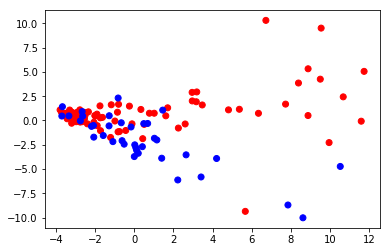

In [111]:
import matplotlib.pyplot as plt
cols=[]
for l in CityNames:
    if l==['Toronto']:
        cols.append('red')
    else:
        cols.append('blue')
    
plt.scatter(principalDf.loc[:,['principal component 1']].values,principalDf.loc[:,['principal component 2']].values,c=cols)
plt.savefig('Neighborhoods_PCA.png')
plt.show()

## The above PCA plot shows the overall differences between the neighborhoods of Toronto (Red) and New York (Blue).
## There are three distinct groups, one covering neighborhoods from both cities, the other with a larger spread and containing only neighborhoods from Toronto, the third an outlier group of only New York

## Now, let's try to see if we can cluster them using k-means
## Let's import the libraries

In [31]:
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

print('Libraries imported.')

Libraries imported.


In [53]:
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)
k_means.fit(CommonVenues)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [54]:
k_means_labels = k_means.labels_
k_means_labels

array([1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2,
       1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 2, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0],
      dtype=int32)

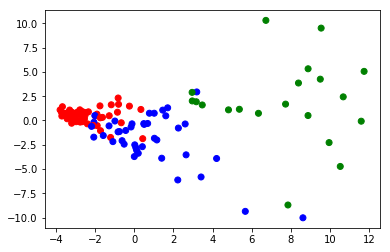

In [115]:
cols=[]
for i in k_means_labels:
    if i == 0:
        cols.append('blue')
    elif i == 1:
        cols.append('red')
    else:
        cols.append('green')

plt.scatter(principalDf.loc[:,['principal component 1']].values,principalDf.loc[:,['principal component 2']].values,c=cols)
plt.savefig('Neighborhoods_KMEANS.png')
plt.show()

## The trend is also reflected in the k-means clustering
## Green: Neighborhoods that are similar across both, Red: Only Toronto, Blue: Only New York dominated
## Now, lets get the members of each cluster.


## Green (Toronto-like Neighbhorhoods, dominated by Neighborhoods from Toronto)

In [113]:
Cluster1_Neighborhoods = temp.loc[k_means_labels==2,['Neighborhood','City']]
Cluster1_Neighborhoods

,Neighborhood,City
2,Berczy Park,Toronto
7,Central Bay Street,Toronto
9,Church and Wellesley,Toronto
22,Garden District,Toronto
30,Kensington Market,Toronto
47,Regent Park,Toronto
48,Richmond,Toronto
49,Riverdale,Toronto
58,St. James Town,Toronto
61,Stn A PO Boxes 25 The Esplanade,Toronto


## Red (Common Kinds of Neighborhoods)

In [114]:
Cluster2_Neighborhoods = temp.loc[k_means_labels==1,['Neighborhood','City']]
Cluster2_Neighborhoods

,Neighborhood,City
0,Agincourt,Toronto
1,Bayview Village,Toronto
3,Business Reply Mail Processing Centre 969 Eastern,Toronto
4,Caledonia-Fairbanks,Toronto
5,Canada Post Gateway Processing Centre,Toronto
6,Cedarbrae,Toronto
8,Christie,Toronto
10,Cliffside West,Toronto
12,Davisville North,Toronto
13,Don Mills North,Toronto


## Blue (NewYork-like Neighborhoods, Dominated by neighborhoods from New York)

In [112]:
Cluster3_Neighborhoods = temp.loc[k_means_labels==0,['Neighborhood','City']]
Cluster3_Neighborhoods

,Neighborhood,City
11,Davisville,Toronto
14,Don Mills South,Toronto
19,Dufferin,Toronto
28,India Bazaar,Toronto
31,L'Amoreaux West,Toronto
33,Lawrence Manor East,Toronto
35,Leaside,Toronto
36,Long Branch,Toronto
37,New Toronto,Toronto
43,Oriole,Toronto


## The above three groups (Cluster1_Neighborhoods, Cluster2_Neighborhoods, Cluster3_Neighborhoods) will be helpful to those shifting from one location to another as well as interested in setting up businesses in similar areas.